In [188]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [189]:
prefix experiments = {
    'baseline': '/home/shane/minerl/pdddqn/result/85a45807b34265153c1859459809b9d49691a674-2f630116-1ee07c14/',
    'k_16': '/home/shane/minerl/pdddqn/result/85a45807b34265153c1859459809b9d49691a674-653f3a8f-ea8043ef/',
    'lr_0002': '/home/shane/minerl/pdddqn/lr-0.0002/85a45807b34265153c1859459809b9d49691a674-653f3a8f-d16ce028/',
    'lr_0006': '/home/shane/minerl/pdddqn/lr-0.0006/85a45807b34265153c1859459809b9d49691a674-653f3a8f-42a918f2/',
    'lr_0002_long': 'lr-0.0002_long/85a45807b34265153c1859459809b9d49691a674-653f3a8f-bc8811fd'

}

In [190]:
rx_dict = {
    'statistics': re.compile(r"statistics:(?P<statistics>.*)\n"),
    'result': re.compile(r"outdir:.* (?P<result>step:(\d+) episode:(\d+) R:(.*))\n")
}
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            #print(key)
            return key, match
    return None, None

In [191]:
# instead, join on episode. But, have to join the lines
train_losses = pd.DataFrame()
train_q_values = pd.DataFrame()
train_rewards = pd.DataFrame()

for name, path in experiments.items():
    statistics = []
    rewards = []
    
    # read the log file, parse the fields, create a statistics and rewards list
    with open(f"{path}log.txt", 'r') as f:
        for line in f:
            key, match = _parse_line(line)
            if key == 'statistics':
                # replace nan with 0
                stats = match.group('statistics').replace('nan', '0.0')
                # convert the list of tuples into a dict
                statistics.append(dict(eval(stats)))

            if key == 'result':
                result = match.group('result').replace('nan', '0.0').split()
                rewards.append(dict(map(lambda s : s.split(':'), result)))

        df = pd.DataFrame(rewards).apply(pd.to_numeric).set_index('episode')
        df = df.join(pd.DataFrame(statistics).set_index('cumulative_steps'), on='step')
        train_losses = pd.concat([train_losses, df['average_loss'].rename(name)], axis=1)
        train_q_values = pd.concat([train_q_values, df['average_q'].rename(name)], axis=1)
        train_rewards = pd.concat([train_rewards, df['R'].rename(name)], axis=1)

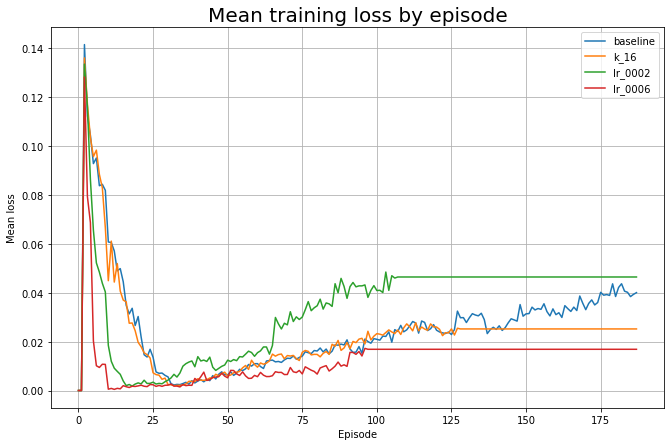

In [199]:
fig, ax = plt.subplots(figsize=(11,7))

train_losses[:188].interpolate().plot(ax=ax)

ax.set_title("Mean training loss by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean loss')
ax.grid()

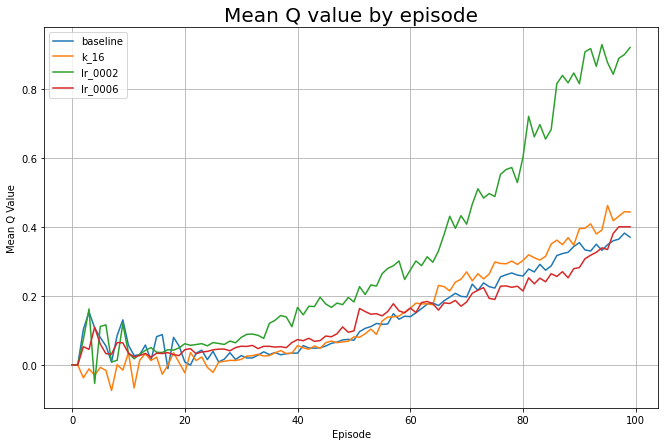

In [193]:
fig, ax = plt.subplots(figsize=(11,7))

train_q_values[:100].interpolate().plot(ax=ax)

ax.set_title("Mean Q value by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Q Value')
ax.grid()


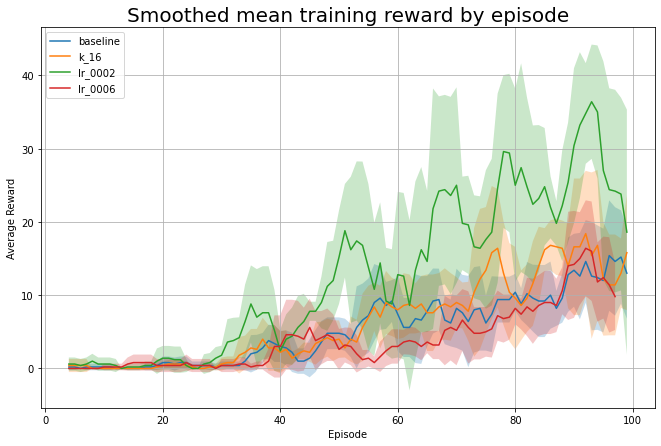

In [194]:
window = 5

fig, ax = plt.subplots(figsize=(11,7))

for name, series in train_rewards[:100].iteritems():
    mean = series.rolling(window).mean()
    sigma = series.rolling(window).std()
    ax.plot(mean, label=name)
    # comment out to remove standard deviation spread
    ax.fill_between(series.index.tolist(), mean+sigma, mean-sigma, alpha=0.25)
    
ax.set_title("Smoothed mean training reward by episode", fontsize=20)
ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

In [195]:
eval_losses = pd.DataFrame()
eval_q_values = pd.DataFrame()
eval_rewards = pd.DataFrame()

for name, path in experiments.items():
    df = pd.read_csv(f"{path}scores.txt", sep="\t").set_index('episodes')
    eval_losses = pd.concat([eval_losses, df['average_loss'].rename(name)], axis=1)
    eval_q_values = pd.concat([eval_q_values, df['average_q'].rename(name)], axis=1)
    eval_rewards = pd.concat([eval_rewards, df['mean'].rename(name)], axis=1) 

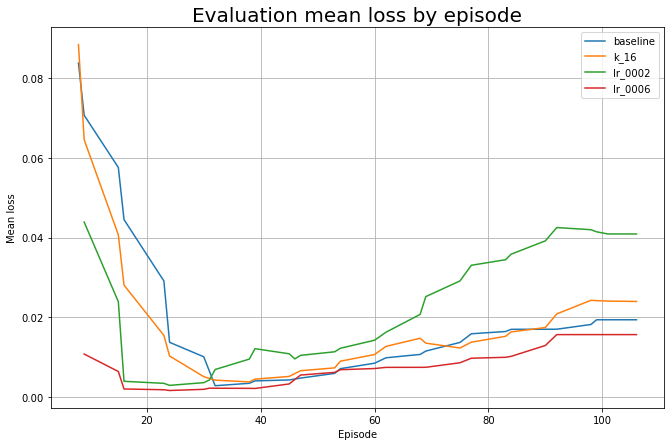

In [196]:
fig, ax = plt.subplots(figsize=(11,7))

eval_losses[:30].interpolate().plot(ax=ax)

ax.set_title("Evaluation mean loss by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean loss')
ax.grid()

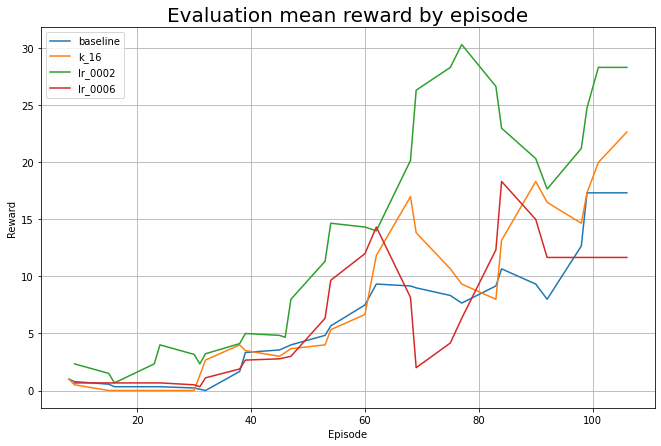

In [197]:
fig, ax = plt.subplots(figsize=(11,7))

eval_rewards[:30].interpolate().plot(ax=ax)
ax.set_title("Evaluation mean reward by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.grid()

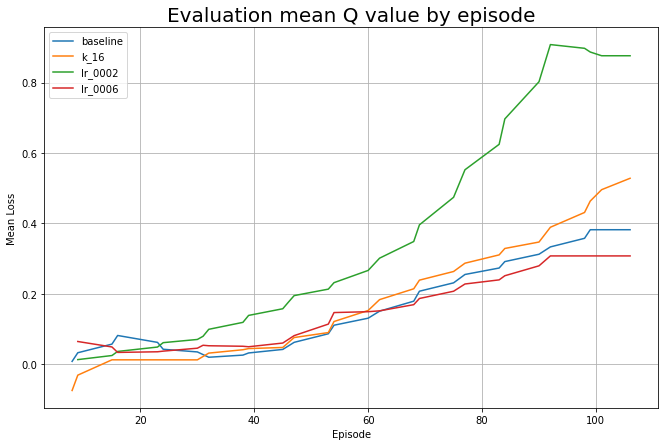

In [198]:
fig, ax = plt.subplots(figsize=(11,7))

eval_q_values[:30].interpolate().plot(ax=ax)

ax.set_title("Evaluation mean Q value by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Loss')
ax.grid()